Uvod u znanost o podacima projekt.

Predviđanje rezultata studenata prema demografskim i socialnim indikatorima.

Unos podataka:

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from bartpy.sklearnmodel import SklearnModel as bart

data_info=pd.read_csv(r'/Users/marko/Downloads/anonymisedData/studentInfo.csv', usecols=['id_student','gender','disability','num_of_prev_attempts','age_band','highest_education','final_result'])
data_stud_assesment=pd.read_csv(r'/Users/marko/Downloads/anonymisedData/studentAssessment.csv', usecols=['id_student','score'])
data_student_vle=pd.read_csv(r'/Users/marko/Downloads/anonymisedData/studentVle.csv', usecols=['id_student','sum_click'])
data_registration=pd.read_csv(r'/Users/marko/Downloads/anonymisedData/studentRegistration.csv', usecols=['id_student','date_registration'])



Priprema podataka:

In [2]:
data_stud_assesment=data_stud_assesment.drop_duplicates(subset=['id_student'])
data_registration=data_registration.drop_duplicates(subset=['id_student'])
data_student_vle=data_student_vle.groupby('id_student',as_index=False)['sum_click'].sum()

Spajanje željenih stupaca u jedan data frame:

In [3]:
podaci=data_info.join(data_student_vle.set_index('id_student'), on='id_student',how='left')
podaci=podaci.join(data_stud_assesment.set_index('id_student'), on='id_student', how='left')
podaci=podaci.join(data_registration.set_index('id_student'), on='id_student', how='left')

Broj studenata po kategorijama:

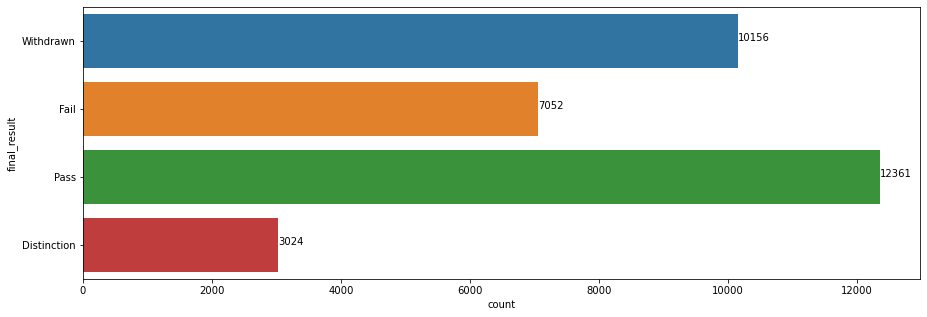

In [4]:
plt.figure(figsize=(15,5))
ax=sns.countplot(y="final_result", data=podaci, order=['Withdrawn','Fail','Pass','Distinction']);
for p in ax.patches:
        percentage = '{}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


Funkcija za korelacijski test:

In [5]:
def chi2_by_hand(df, col1, col2):    
    #---create the contingency table---
    df_cont = pd.crosstab(index = df[col1], columns = df[col2])
    #display(df_cont)
    #---calculate degree of freedom---
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    #---sum up the totals for row and columns---
    df_cont.loc[:,'Total']= df_cont.sum(axis=1)
    df_cont.loc['Total']= df_cont.sum()
    #print('---Observed (O)---')
    #display(df_cont)
    #---create the expected value dataframe---
    df_exp = df_cont.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(df_cont.sum(1).values,df_cont.sum().values)/df_cont.sum().sum()            
    #print('---Expected (E)---')
    #display(df_exp)
        
    # calculate chi-square values
    df_chi2 = ((df_cont - df_exp)**2) / df_exp    
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()
    
    #print('---Chi-Square---')
    #display(df_chi2)
    #---get chi-square score---   
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    
    #---calculate the p-value---
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    
    return chi_square_score, degree_f, p

P_vrijednosti=[]
varijable=['age_band','disability','gender','highest_education']
for i in varijable:
    chi,degree,p_value=chi2_by_hand(data_info,'final_result',i)
    P_vrijednosti.append(p_value)

P vrijednosti:

In [6]:
print(P_vrijednosti)

[2.831091467088581e-45, 8.143196121271435e-30, 0.0008827203938431326, 9.182113007265443e-212]


Sve p vrijednosti su manje od 5%

Priprema podataka:

In [7]:
podaci['gender'].replace({'M':1,'F':0}, inplace=True)
podaci['highest_education'].replace({'HE Qualification':0,'Post Graduate Qualification':0,'A Level or Equivalent':0, 'Lower Than A Level':0, 'No Formal quals':1}, inplace=True)
podaci['age_band'].replace({'0-35':1,'35-55':0,'55<=':0}, inplace=True)
podaci['disability'].replace({'Y':0,'N':1}, inplace=True)
podaci=podaci.rename(columns={'gender':'Gender','age_band':'Age','num_of_prev_attempts':'Previous Attempts','disability':'Disability','score':'First Assignment Mark','highest_education':'Educational Level','date_registration':'Registration Date','sum_click':'Clicks till Course Starts'})
podaci=podaci.fillna(0)

Sada corelacijski test:

In [8]:
lista=['Gender','Educational Level','Age','Previous Attempts','Disability','First Assignment Mark','Registration Date','Clicks till Course Starts']
Matrica=podaci[lista].corr()
Matrica=Matrica.round(decimals=2)
Matrica

,Gender,Educational Level,Age,Previous Attempts,Disability,First Assignment Mark,Registration Date,Clicks till Course Starts
Gender,1.00,-0.03,0.03,-0.03,0.04,0.08,-0.03,0.17
Educational Level,-0.03,1.00,0.03,0.01,0.03,-0.04,-0.00,-0.02
Age,0.03,0.03,1.00,-0.01,-0.02,-0.04,-0.04,-0.13
Previous Attempts,-0.03,0.01,-0.01,1.00,-0.05,-0.04,-0.03,-0.05
Disability,0.04,0.03,-0.02,-0.05,1.00,0.04,0.01,0.03
First Assignment Mark,0.08,-0.04,-0.04,-0.04,0.04,1.00,0.08,0.39
Registration Date,-0.03,-0.00,-0.04,-0.03,0.01,0.08,1.00,-0.03
Clicks till Course Starts,0.17,-0.02,-0.13,-0.05,0.03,0.39,-0.03,1.00


Izgradnja Decision tree-a

Prvo podjela podataka na Ulaz i izlaz, te train i test:

In [9]:
X = podaci[lista]
y = podaci['final_result']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

Izgradnja modela:

In [10]:
DecisionTree=DecisionTreeClassifier()
DecisionTree=DecisionTree.fit(X_train,y_train)

Predikcija=DecisionTree.predict(X_test)

In [11]:
(Predikcija =='Withdrawn').sum()
(Predikcija =='Pass').sum()/len(Predikcija)
(Predikcija =='Fail').sum()/len(Predikcija)
(Predikcija =='Distinction').sum()/len(Predikcija)

0.09623644917160974

In [12]:
Precision_DT, recall_DT, F1_DT, support_DT=precision_recall_fscore_support(y_test, Predikcija)
Accuracy_W_DT=round((Predikcija =='Withdrawn').sum()/len(Predikcija),2)
Accuracy_F_DT=round((Predikcija =='Fail').sum()/len(Predikcija),2)
Accuracy_P_DT=round((Predikcija =='Pass').sum()/len(Predikcija),2)
Accuracy_D_DT=round((Predikcija =='Distinction').sum()/len(Predikcija),2)

Precision_W_DT=round(Precision_DT[3],2)
Precision_F_DT=round(Precision_DT[1],2)
Precision_P_DT=round(Precision_DT[2],2)
Precision_D_DT=round(Precision_DT[0],2)

recall_W_DT=round(recall_DT[3],2)
recall_F_DT=round(recall_DT[1],2)
recall_P_DT=round(recall_DT[2],2)
recall_D_DT=round(recall_DT[0],2)

F1_W_DT=round(F1_DT[3],2)
F1_F_DT=round(F1_DT[1],2)
F1_P_DT=round(F1_DT[2],2)
F1_D_DT=round(F1_DT[0],2)


#print('precision: {}'.format(Precision_DT))
#print('recall: {}'.format(recall_DT))
#print('fscore: {}'.format(F1_DT))
#print('support: {}'.format(support_DT))
#print(y_test.value_counts())

Izgradnja Random forest modela:

In [13]:
RandomForest=RandomForestClassifier()
RandomForest=RandomForest.fit(X_train, y_train)

Predikcija_RF=RandomForest.predict(X_test)

Evaluacija modela:

In [14]:
Precision_RF, recall_RF, F1_RF, support_RF=precision_recall_fscore_support(y_test, Predikcija_RF)
Accuracy_W_RF=round((Predikcija_RF =='Withdrawn').sum()/len(Predikcija_RF),2)
Accuracy_F_RF=round((Predikcija_RF =='Fail').sum()/len(Predikcija_RF),2)
Accuracy_P_RF=round((Predikcija_RF =='Pass').sum()/len(Predikcija_RF),2)
Accuracy_D_RF=round((Predikcija_RF =='Distinction').sum()/len(Predikcija_RF),2)

Precision_W_RF=round(Precision_RF[3],2)
Precision_F_RF=round(Precision_RF[1],2)
Precision_P_RF=round(Precision_RF[2],2)
Precision_D_RF=round(Precision_RF[0],2)

recall_W_RF=round(recall_RF[3],2)
recall_F_RF=round(recall_RF[1],2)
recall_P_RF=round(recall_RF[2],2)
recall_D_RF=round(recall_RF[0],2)

F1_W_RF=round(F1_RF[3],2)
F1_F_RF=round(F1_RF[1],2)
F1_P_RF=round(F1_RF[2],2)
F1_D_RF=round(F1_RF[0],2)

Priprema podataka za BART

In [17]:
y_train1=y_train.replace({'Withdrawn':1,'Fail':0,'Pass':0,'Distinction':0})
y_train2=y_train.replace({'Withdrawn':0,'Fail':1,'Pass':0,'Distinction':0})
y_train3=y_train.replace({'Withdrawn':0,'Fail':0,'Pass':1,'Distinction':0})
y_train4=y_train.replace({'Withdrawn':0,'Fail':0,'Pass':0,'Distinction':1})

Izgradnja Bart modela:

In [19]:
Bart_W=bart()
Bart_W=Bart_W.fit(X_train,y_train1)

Predikcija_Bart_W=Bart_W.predict(X_test)

In [20]:
Bart_F=bart()
Bart_F=Bart_F.fit(X_train,y_train2)

Predikcija_Bart_F=Bart_F.predict(X_test)

In [21]:
Bart_P=bart()
Bart_P=Bart_P.fit(X_train,y_train3)

Predikcija_Bart_P=Bart_P.predict(X_test)

In [22]:
Bart_D=bart()
Bart_D=Bart_D.fit(X_train,y_train4)

Predikcija_Bart_D=Bart_D.predict(X_test)

In [26]:
Predikcija_Bart_W=np.where(Predikcija_Bart_W<0.5,0,Predikcija_Bart_W)
Predikcija_Bart_W=np.where(Predikcija_Bart_W>=0.5,1,Predikcija_Bart_W)

Predikcija_Bart_F=np.where(Predikcija_Bart_F<0.5,0,Predikcija_Bart_F)
Predikcija_Bart_F=np.where(Predikcija_Bart_F>=0.5,1,Predikcija_Bart_F)

Predikcija_Bart_P=np.where(Predikcija_Bart_P<0.5,0,Predikcija_Bart_P)
Predikcija_Bart_P=np.where(Predikcija_Bart_P>=0.5,1,Predikcija_Bart_P)

Predikcija_Bart_D=np.where(Predikcija_Bart_D<0.5,0,Predikcija_Bart_D)
Predikcija_Bart_D=np.where(Predikcija_Bart_D>=0.5,1,Predikcija_Bart_D)


In [27]:
y_test1=y_test.replace({'Withdrawn':1,'Fail':0,'Pass':0,'Distinction':0})
y_test2=y_test.replace({'Withdrawn':0,'Fail':1,'Pass':0,'Distinction':0})
y_test3=y_test.replace({'Withdrawn':0,'Fail':0,'Pass':1,'Distinction':0})
y_test4=y_test.replace({'Withdrawn':0,'Fail':0,'Pass':0,'Distinction':1})


Precision_Bart_W, recall_Bart_W, F1_Bart_W, support_Bart_W=precision_recall_fscore_support(y_test1, Predikcija_Bart_W)

Precision_Bart_F, recall_Bart_F, F1_Bart_F, support_Bart_F=precision_recall_fscore_support(y_test2, Predikcija_Bart_F)

Precision_Bart_P, recall_Bart_P, F1_Bart_P, support_Bart_P=precision_recall_fscore_support(y_test3, Predikcija_Bart_P)

Precision_Bart_D, recall_Bart_D, F1_Bart_D, support_Bart_D=precision_recall_fscore_support(y_test4, Predikcija_Bart_D)

Accuracy_W_Bart=round((Predikcija_Bart_W ==1).sum()/len(Predikcija_Bart_W),2)
Accuracy_F_Bart=round((Predikcija_Bart_F ==1).sum()/len(Predikcija_RF),2)
Accuracy_P_Bart=round((Predikcija_Bart_P ==1).sum()/len(Predikcija_RF),2)
Accuracy_D_Bart=round((Predikcija_Bart_D ==1).sum()/len(Predikcija_RF),2)

In [55]:
print(Precision_Bart_W)

[0.80070814 0.78395722]


In [72]:
print('\033[1m'+"Withdrawn"+'\033[0m'+'     '+'DT'+'       '+'RF'+'       '+'BART')
print('Precision'+'     '+str(Precision_W_DT)+'     '+str(Precision_W_RF)+'     '+str(round(Precision_Bart_W[0],2)))
print('Recall   '+'     '+str(recall_W_DT)+'     '+str(recall_W_RF)+'     '+str(round(recall_Bart_W[0],2)))
print('F1       '+'     '+str(F1_W_DT)+'     '+str(recall_W_RF)+'     '+str(round(F1_Bart_W[0],2)))
print('Accuracy '+'     '+str(Accuracy_W_DT)+'     '+str(recall_W_RF)+'     '+str(1-Accuracy_W_Bart))
print('\n')
print('\033[1m'+"Fail"+'\033[0m'+'          '+'DT'+'       '+'RF'+'       '+'BART')
print('Precision'+'     '+str(Precision_F_DT)+'     '+str(Precision_F_RF)+'     '+str(round(Precision_Bart_F[0],2)))
print('Recall   '+'     '+str(recall_F_DT)+'     '+str(recall_F_RF)+'     '+str(round(recall_Bart_F[0],2)))
print('F1       '+'     '+str(F1_F_DT)+'     '+str(recall_F_RF)+'     '+str(round(F1_Bart_F[0],2)))
print('Accuracy '+'     '+str(Accuracy_F_DT)+'     '+str(recall_F_RF)+'     '+str(1-Accuracy_F_Bart))
print('\n')
print('\033[1m'+"Pass"+'\033[0m'+'          '+'DT'+'       '+'RF'+'       '+'BART')
print('Precision'+'     '+str(Precision_P_DT)+'     '+str(Precision_P_RF)+'     '+str(round(Precision_Bart_P[0],2)))
print('Recall   '+'     '+str(recall_P_DT)+'     '+str(recall_P_RF)+'     '+str(round(recall_Bart_P[0],2)))
print('F1       '+'     '+str(F1_P_DT)+'     '+str(recall_P_RF)+'     '+str(round(F1_Bart_P[0],2)))
print('Accuracy '+'     '+str(Accuracy_P_DT)+'     '+str(recall_P_RF)+'     '+str(1-Accuracy_P_Bart))
print('\n')
print('\033[1m'+"Distinction"+'\033[0m'+'   '+'DT'+'       '+'RF'+'       '+'BART')
print('Precision'+'     '+str(Precision_D_DT)+'     '+str(Precision_D_RF)+'     '+str(round(Precision_Bart_D[0],2)))
print('Recall   '+'     '+str(recall_D_DT)+'     '+str(recall_D_RF)+'     '+str(round(recall_Bart_D[0],2)))
print('F1       '+'     '+str(F1_D_DT)+'     '+str(recall_D_RF)+'     '+str(round(F1_Bart_D[0],2)))
print('Accuracy '+'     '+str(Accuracy_D_DT)+'      '+str(recall_D_RF)+'     '+str(1-Accuracy_D_Bart))

Withdrawn     DT       RF       BART
Precision     0.53     0.61     0.8
Recall        0.53     0.56     0.94
F1            0.53     0.56     0.86
Accuracy      0.31     0.56     0.81


Fail          DT       RF       BART
Precision     0.32     0.39     0.8
Recall        0.35     0.33     0.99
F1            0.33     0.33     0.88
Accuracy      0.23     0.33     0.97


Pass          DT       RF       BART
Precision     0.55     0.57     0.76
Recall        0.52     0.72     0.75
F1            0.53     0.72     0.76
Accuracy      0.36     0.72     0.6


Distinction   DT       RF       BART
Precision     0.27     0.34     0.91
Recall        0.27     0.18     1.0
F1            0.27     0.18     0.95
Accuracy      0.1      0.18     0.99


Confusion matrix za pass vs rest.

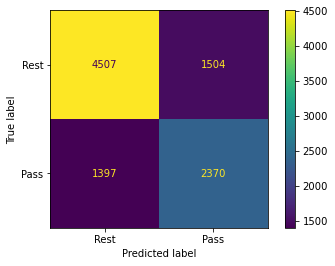

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test3, Predikcija_Bart_P)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rest','Pass'])
disp.plot();

In [44]:
Predikcija=np.where(Predikcija=='Distinction',1,Predikcija)
Predikcija=np.where(Predikcija!=1,0,Predikcija)
Predikcija_RF=np.where(Predikcija_RF=='Distinction',1,Predikcija_RF)
Predikcija_RF=np.where(Predikcija_RF!=1,0,Predikcija_RF)

[0 0 1 ... 0 1 0]


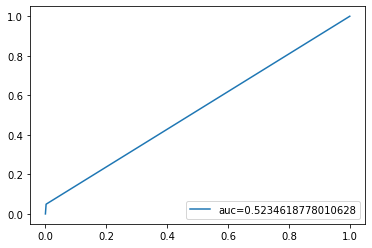

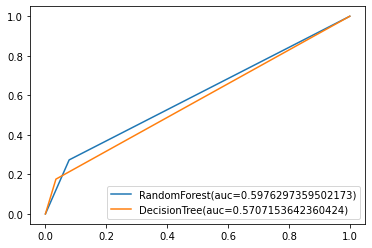

In [46]:
fpr, tpr, _ = metrics.roc_curve(y_test4,  Predikcija_Bart_D)
auc = metrics.roc_auc_score(y_test4, Predikcija_Bart_D)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

fpr2, tpr2, _ = metrics.roc_curve(y_test4,  Predikcija)
auc1 = metrics.roc_auc_score(y_test4, Predikcija)
plt.plot(fpr2,tpr2,label="RandomForest(auc="+str(auc1)+")")
fpr3, tpr3, _ = metrics.roc_curve(y_test4,  Predikcija_RF)
auc2 = metrics.roc_auc_score(y_test4, Predikcija_RF)
plt.plot(fpr3,tpr3,label="DecisionTree(auc="+str(auc2)+")")
plt.legend(loc=4)

Odnos između broja klikova studenata i krajnjem rezultatu:


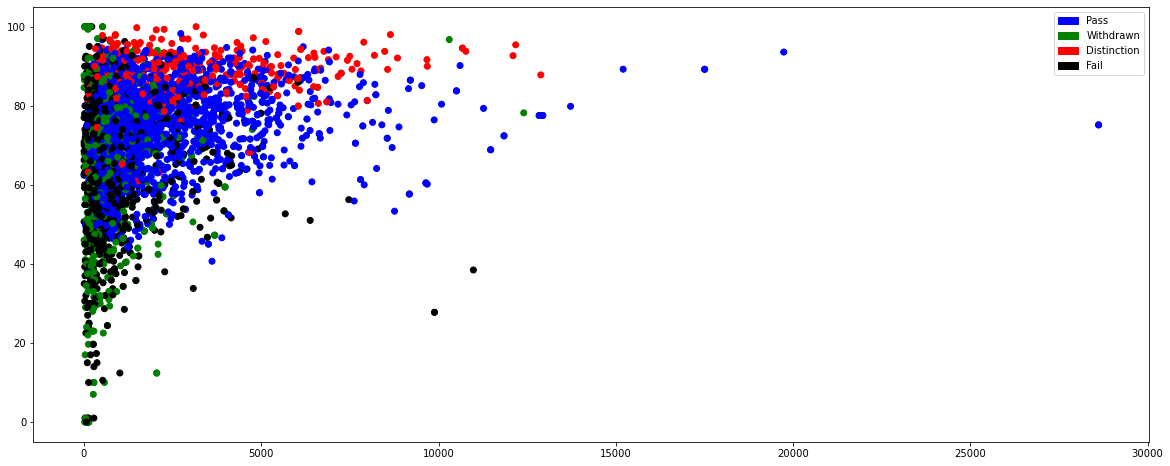

In [91]:
import matplotlib.patches as mpatches

data_stud=pd.read_csv(r'/Users/marko/Downloads/anonymisedData/studentAssessment.csv', usecols=['id_student','score'])
data_stud=data_stud.groupby('id_student', as_index=False)['score'].mean()
graf_podaci=data_stud.join(podaci.set_index('id_student'), on='id_student', how='left')
plt.figure(figsize=(20,8))
boje={'Pass':'blue','Withdrawn':'Green','Distinction':'red','Fail':'black'}
plt.scatter(graf_podaci['Clicks till Course Starts'][0:4000],graf_podaci['score'][0:4000],c=graf_podaci['final_result'][0:4000].map(boje));
pop_a = mpatches.Patch(color='blue', label='Pass')
pop_b = mpatches.Patch(color='Green', label='Withdrawn')
pop_c = mpatches.Patch(color='red', label='Distinction')
pop_d = mpatches.Patch(color='black', label='Fail')

plt.legend(handles=[pop_a,pop_b,pop_c,pop_d]);

Vrsta istraživanja prema:

svrsi - teoretsko istraživanje ... stvaranje teoretskog predviđanja.

izvoru informacija - primarno istraživanje ... koriste se podaci prikupljeni pri prijavi studenata na Open University

vremenu provedbe - studija presjeka (sinkrono istraživanje) ... promatra se mnogo različitih uzoraka, svaki se gleda u samo jednoj točki u vremenu

načinu prikupljanja podataka - dokumentarno ... izolirana je zavisna varijabla (Finalni rezultat studenta) i uspostavlja se odnos s drugim varijablama

vrsti korištenih podataka - kvantitativno ... koriste se mjerljive varijable, korištenje statistike, može se ponoviti istraživanje u svrhu potvrde rezultata

stupnju manipulacije varijablama - promatračko istraživanje ... nema interakscije s varijablama, samo mjerenje za potrebe istraživanja

dubini - korelacijsko istraživanje ... ovisnost zavisne varijable o ostalim varijablama

vrsti zaključka - induktivno istraživanje ... analiza promatranog, znanje se generira promatranjem kako bi se postigla generalizacija

Metode kako su podaci prikupljeni:

Metoda koja najviše odgovara prikupljanju podatak za zadani rad je dokumentarno istraživanje.

Jesu li podaci prikupljeni i objavljeni prema pravilima istraživačke etike?

Prikupljanje i objavljivanje podataka u potpunosti je u skladu s pravilima istraživačke etike.